In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score

%matplotlib inline

# Read data

In [49]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
all_df = train_df.append(test_df)

all_df['is_test'] = all_df.Survived.isnull()
all_df.index = all_df.Survived

In [50]:
all_df.shape

(1309, 13)

# Target variable

Target variable is **Survived**.

# Quality metric

Your score is the percentage of passengers you correctly predict. That means - **accuracy**.

# Model

## One variable model
Let's build a very simple model, based on one variable.
That nobody will survived.

In [96]:
def select_features(df):
    non_obj_feats = df.columns[ df.dtypes != 'object' ]
    black_list = ['PassengerId', 'is_test', 'Survived']
    
    return [feat for feat in non_obj_feats if feat not in black_list ]

def get_X_y(df):
    feats = select_features(df)
    
    X = df[feats].values
    y = df.index.values.astype(int)
    
    return X, y

def check_quality(model, X, y, n_folds=5, random_state=0, shuffle=True):
    skf = StratifiedKFold(y, n_folds=n_folds, random_state=random_state, shuffle=shuffle)
    scores = []
    
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        
        scores.append(score)
        
    return np.mean(scores), np.std(scores)

def train_and_verify(df, model):
    X, y = get_X_y( df[ df.is_test == False ] )
    return check_quality(model, X, y)

def predict_and_save(df, model, file_name):
    df_test = df[ df.is_test == True ]
    X_test = df_test[ select_features( df_test ) ].values
    
    df_subm = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived"   : model.predict(X_test)
    })
    
    df_subm.to_csv(file_name, index=False)

def iteration_modeling(all_df, model = RandomForestClassifier(), iterations=300):
    res = [train_and_verify(all_df, model)[0] for x in range(iterations)]
    return {'min': np.min(res), 'mean': np.mean(res), 'max': np.max(res) }

def get_importance_features(data, model, limit):
    X,y = get_X_y(data)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort_values(by=[0], ascending=False) [:limit]
    return feats.rename(columns={0:'feature'})
    
def draw_importance_features(data, model=RandomForestClassifier(), limit=30):
    feats = get_importance_features(data, model, limit)
    feats.plot(kind='bar', figsize=(20, 8))
    
def handle_cat_var(all_df, name):
    unique_values = all_df[name].unique()
    
    #========= probability
    for value in unique_values:
        x_all = all_df[ (all_df[name] == value) ].shape[0]
        x_survived = all_df[ (all_df[name] == value) & (all_df.index == 1) ].shape[0]

        all_df['{0}_{1}_prob_surv'.format(name, value)] = x_survived / float(x_all)
        all_df['{0}_{1}_prob_not_surv'.format(name, value)] = 1.0 - all_df['{0}_{1}_prob_surv'.format(name, value)]
        
    #========= category to unique id
    name_idx, name_labes = pd.factorize(all_df[name])
    all_df['{0}_idx'.format(name)] = name_idx
    
    #========= one hot encoding
    first_value = unique_values[0]
    if '{0}_{1}'.format(name, first_value) not in all_df:
        one_hot = pd.get_dummies( all_df[name], prefix=name)
        all_df = pd.concat( [all_df, one_hot], axis=1 )
        
    return all_df

In [55]:
class SingleVariableModel(BaseEstimator, ClassifierMixin):
    def __init__(self, seed=1):
        np.random.seed(seed)

    def fit(self, X, y):
        return self
        
    def predict(self, X):
        return [0] * len(X)
    
    def __repr__(self):
        return 'SingleVariableModel'

## Run & evoluate single variable model

In [56]:
train_and_verify(all_df, SingleVariableModel())

(0.61616490890978648, 0.0015536004208290756)

**What do you think about this result?**

## Let's build more advanced model

### Missing values
There're several methods how to manage missing values, let's fill out -1.

In [57]:
all_df.fillna(-1, inplace=True)

In [58]:
iteration_modeling(all_df)

{'max': 0.7081816108805381,
 'mean': 0.68742226558247121,
 'min': 0.66217033414225968}

The result looks better than previous one (**0.616** vs **0.68**).  
Let's improve it... by using those features `['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket']`

{'max': 0.81933745350269371, 'mean': 0.79598763133527461, 'min': 0.77889986016674306}


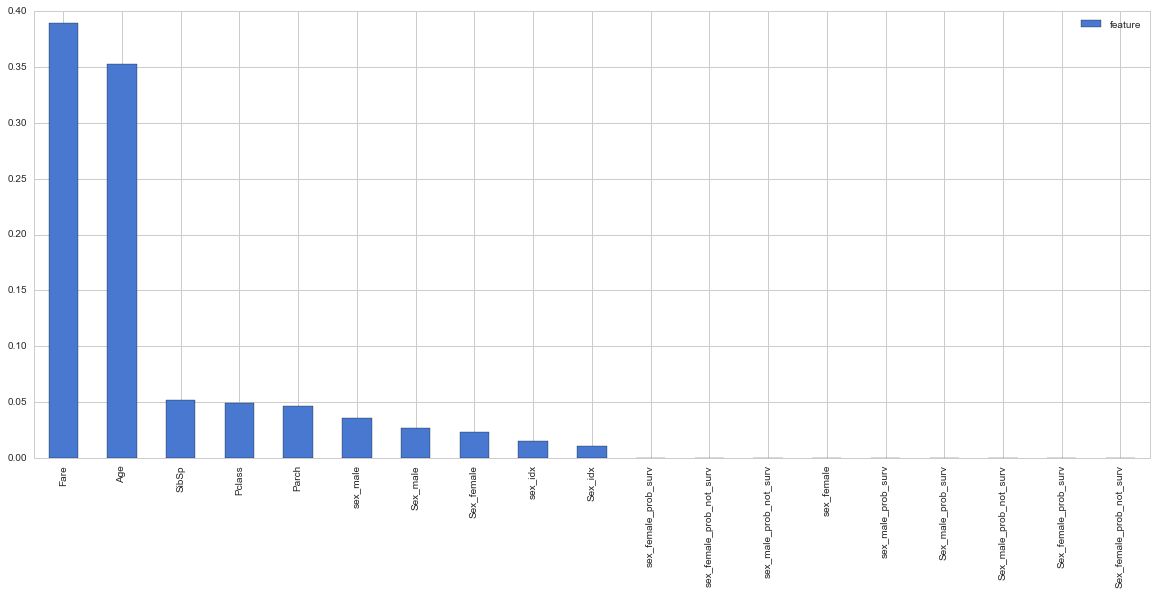

In [98]:
all_df = handle_cat_var(all_df, 'Sex')
print iteration_modeling(all_df)

draw_importance_features(all_df)

The result looks better than previous one (**0.68** vs **0.79**).  

Next features wchich could improve quality the model

In [99]:
all_df[ ['Name', 'Cabin', 'Embarked', 'Ticket'] ].head()

,Name,Cabin,Embarked,Ticket
Survived,,,,
0.0,"Braund, Mr. Owen Harris",-1,S,A/5 21171
1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,C,PC 17599
1.0,"Heikkinen, Miss. Laina",-1,S,STON/O2. 3101282
1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,S,113803
0.0,"Allen, Mr. William Henry",-1,S,373450


Prefix in names, let's try use it.

In [100]:
all_df['prefix_name'] = all_df['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip().lower() )

In [102]:
all_df['prefix_name'].value_counts()

mr              757
miss            260
mrs             197
master           61
dr                8
rev               8
col               4
ms                2
mlle              2
major             2
lady              1
sir               1
mme               1
capt              1
don               1
jonkheer          1
dona              1
the countess      1
Name: prefix_name, dtype: int64

Let's use **mr**, **miss**, **mrs**, **master** and *other*

In [103]:
all_df['prefix_name_'] = all_df['prefix_name'].map(lambda x: x if x in ["mr", "miss", "mrs", "master"] else "other" )

In [104]:
all_df['prefix_name_'].value_counts()

mr        757
miss      260
mrs       197
master     61
other      34
Name: prefix_name_, dtype: int64

{'max': 0.82602239105294117, 'mean': 0.80910723114901939, 'min': 0.78898097622267216}


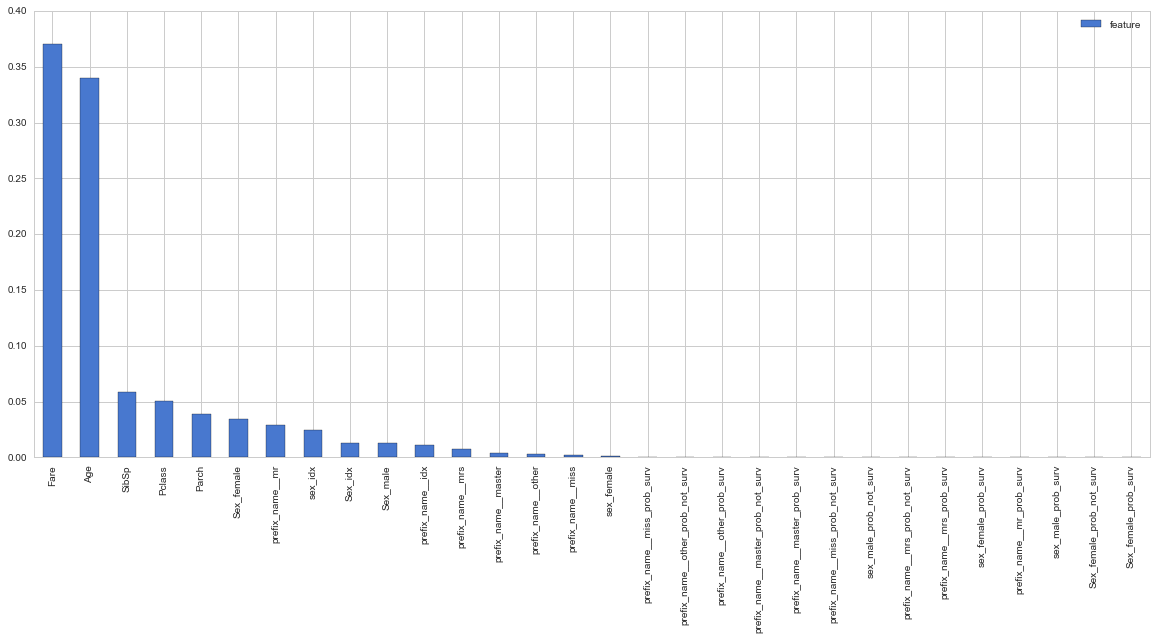

In [105]:
all_df = handle_cat_var(all_df, 'prefix_name_')
print iteration_modeling(all_df)

draw_importance_features(all_df)

The result looks better than previous one (**0.79** vs **0.81**).  

Let's extract first letter from **Cabin**

{'max': 0.83166576056985853, 'mean': 0.81072374000825831, 'min': 0.79459909560544817}


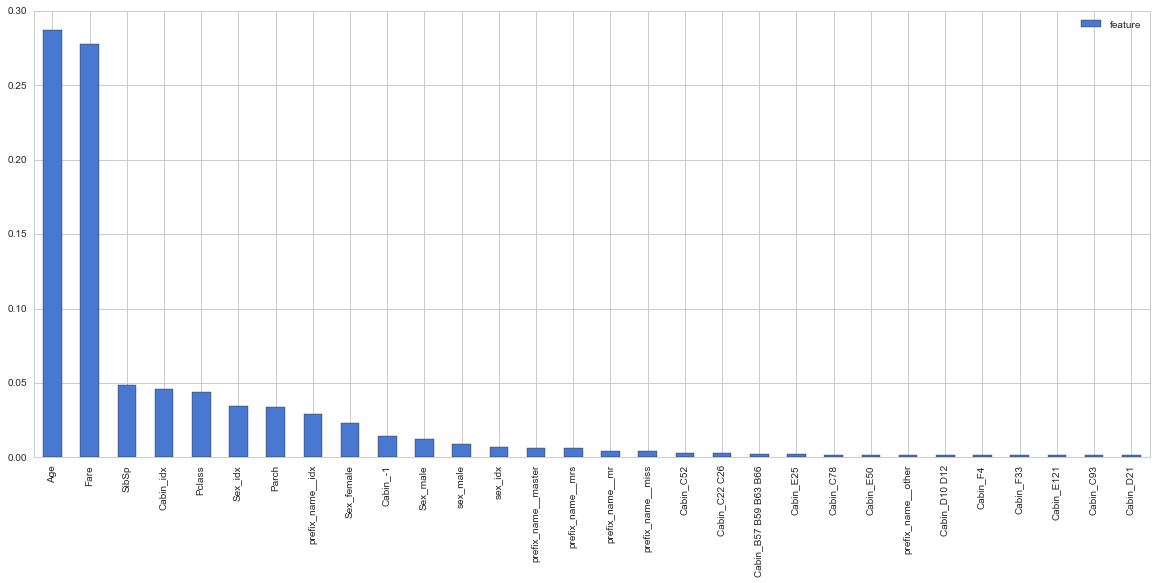

In [109]:
all_df = handle_cat_var(all_df, 'Cabin')
print iteration_modeling(all_df)

draw_importance_features(all_df)

In [110]:
all_df['deck'] = all_df['Cabin'].map(lambda x:  "missing" if x == -1 else x.strip()[0])
all_df['deck'].value_counts()

missing    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: deck, dtype: int64

{'max': 0.82383204830719481, 'mean': 0.80797297148094283, 'min': 0.78901870956919795}


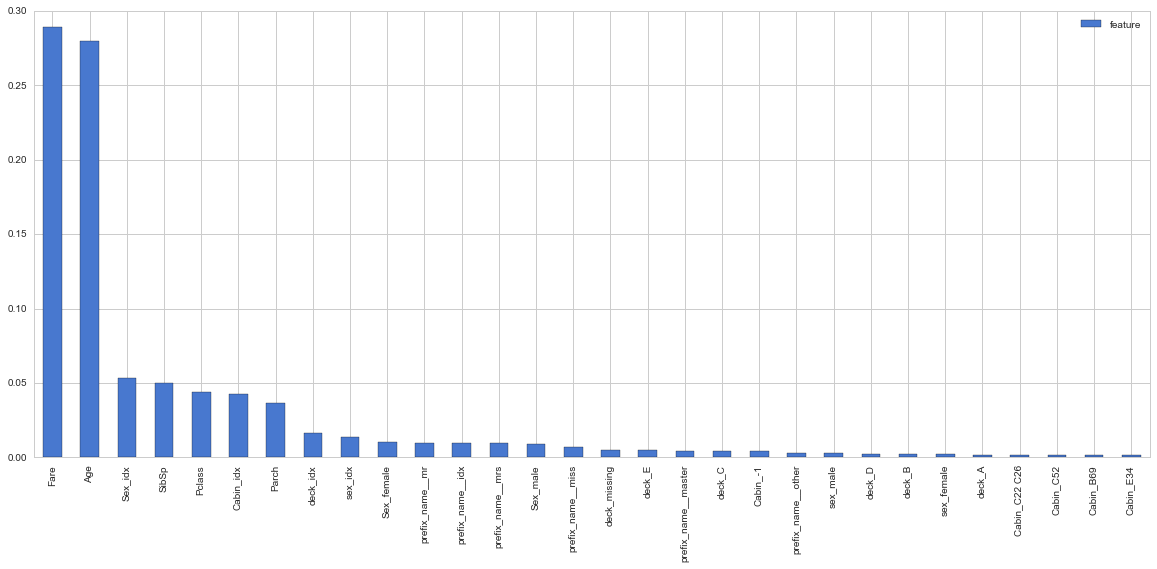

In [111]:
all_df = handle_cat_var(all_df, 'deck')
print iteration_modeling(all_df)

draw_importance_features(all_df)

The result looks the same or a bit worse (**0.81** vs **0.81**).
Let's focus on **Embarked**

In [113]:
all_df['Embarked'].replace(-1, 'missing', inplace=True)
all_df['Embarked'].value_counts()

S          914
C          270
Q          123
missing      2
Name: Embarked, dtype: int64

{'max': 0.82381307524291714, 'mean': 0.80316253390770287, 'min': 0.78458110488487254}


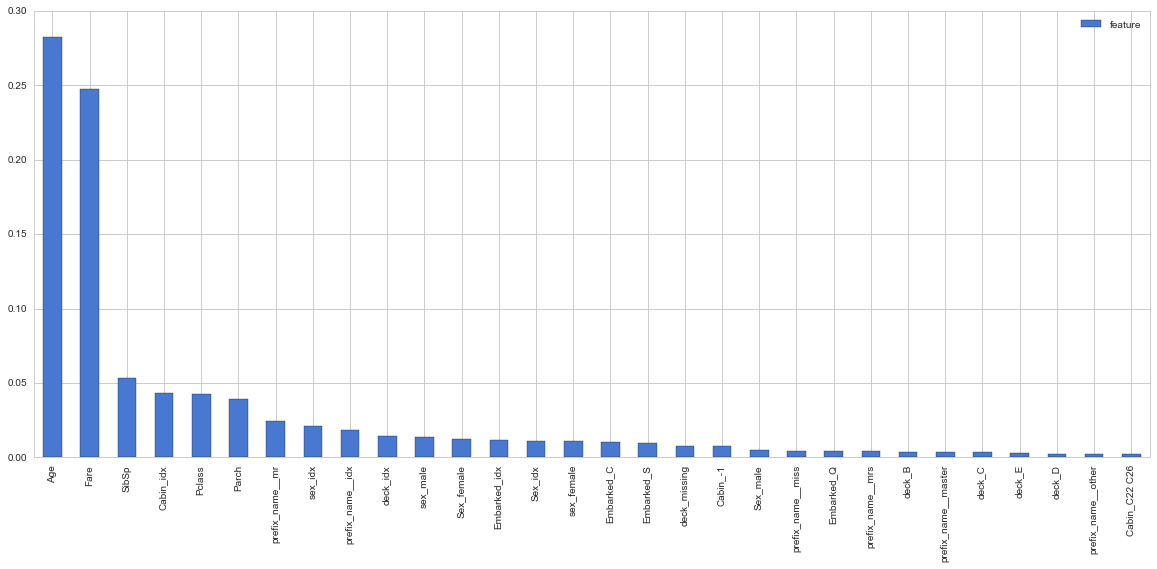

In [114]:
all_df = handle_cat_var(all_df, 'Embarked')
print iteration_modeling(all_df)

draw_importance_features(all_df)

Looks more or less the same (event a bit worse)... let's focus on the **Parch** and **SibSp**

* **Sibsp** - Number of Siblings/Spouses Aboard
* **Parch** - Number of Parents/Children Aboard

In [115]:
all_df['Parch'].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [116]:
all_df['SibSp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [117]:
all_df['sigle'] = all_df.apply(lambda x: 1 if x['Parch'] == x['SibSp'] else 0, axis=1)
all_df['count_relations'] = all_df['Parch'] + all_df['SibSp']

all_df['family_index'] = all_df.apply(lambda x: 'nofamily' if x['count_relations'] == 0 else '{0}-{1}'.format(x['Name'].split(',')[0].strip(), x['count_relations']), axis=1)

In [120]:
all_df['family_index'].value_counts()

nofamily             790
Sage-10               11
Andersson-6            9
Goodwin-7              8
Asplund-6              7
Fortune-5              6
Rice-5                 6
Panula-5               6
Skoog-5                6
Davies-2               5
Palsson-4              5
Ryerson-4              5
Ford-4                 5
Lefebre-4              5
Harper-1               4
Allison-3              4
Brown-2                4
Dean-3                 4
Baclini-3              4
Herman-3               4
Becker-3               4
Johnston-3             4
Laroche-3              4
Carter-3               4
West-3                 4
Johnson-2              3
Widener-2              3
Hickman-2              3
Hart-2                 3
Thayer-2               3
                    ... 
Jacobsohn-3            1
Frolicher-2            1
Jacobsohn-1            1
Bowerman-1             1
Richards-5             1
Hirvonen-2             1
Chibnall-1             1
Cornell-2              1
Hirvonen-1             1


{'max': 0.82827607191607022, 'mean': 0.8041068345469593, 'min': 0.77895028950768275}


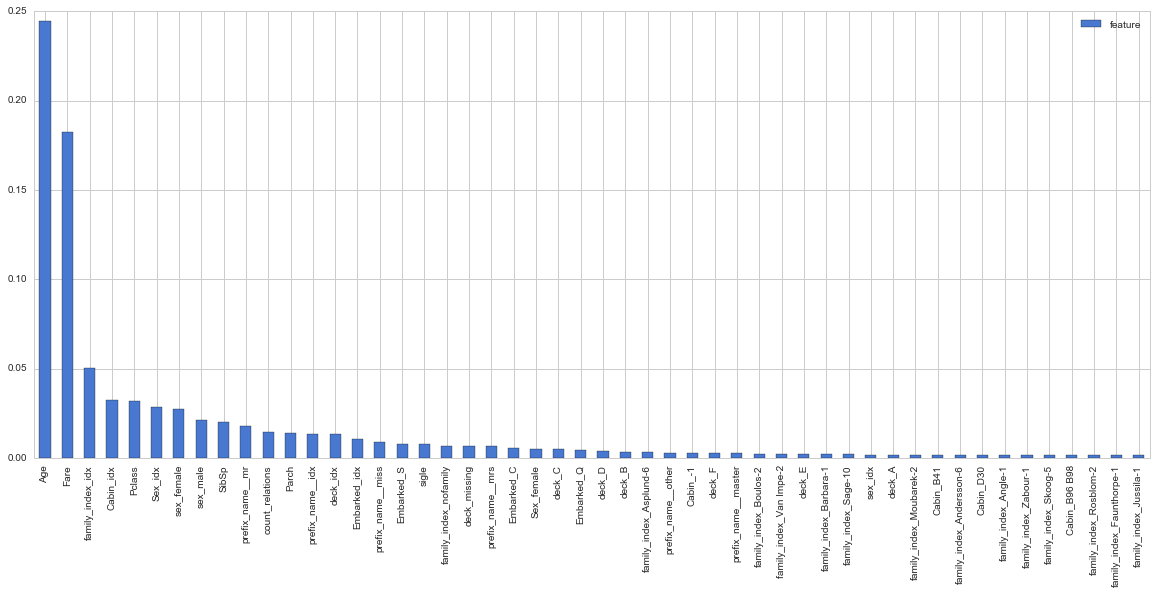

In [121]:
all_df = handle_cat_var(all_df, 'family_index')
print iteration_modeling(all_df)

draw_importance_features(all_df, limit=50)

Let's focus on **Fare**

In [125]:
print 'mean'
print all_df.groupby(['Pclass', 'Sex']).agg(np.mean)['Fare'].reset_index()
print
print 'median'
print all_df.groupby(['Pclass', 'Sex']).agg(np.median)['Fare'].reset_index()

mean
   Pclass     Sex        Fare
0       1  female  109.412385
1       1    male   69.888385
2       2  female   23.234827
3       2    male   19.904946
4       3  female   15.324250
5       3    male   12.388250

median
   Pclass     Sex      Fare
0       1  female  80.92915
1       1    male  49.50420
2       2  female  23.00000
3       2    male  13.00000
4       3  female  10.48960
5       3    male   7.89580


Interesting... for some reason the tickets are bought by female is more expensive.

In [145]:
all_df['fare_log'] = all_df['Fare'].map( lambda x: x if x <= 0 else int(np.log2(x)) )
all_df['fare_log'].value_counts()

 3.0    354
 2.0    342
 4.0    283
 5.0    135
 6.0    109
 7.0     50
 0.0     17
 8.0     13
 9.0      4
-1.0      1
 1.0      1
Name: fare_log, dtype: int64

In [146]:
def call_diff(x, dict_fare, percentage=False):
    key = (x['Pclass'], x['Sex'])
    diff = x['Fare'] - dict_fare[key]
    
    diff_per = np.abs(diff / x['Fare']) if x['Fare'] > 0 else 0.0
    return diff_per if percentage else diff

fare_median = all_df.groupby(['Pclass', 'Sex']).agg(np.median)['Fare'].to_dict()
fare_mean = all_df.groupby(['Pclass', 'Sex']).agg(np.mean)['Fare'].to_dict()

all_df['diff_fare_median'] = all_df.apply(lambda x: call_diff(x, fare_median), axis=1)
all_df['diff_fare_mean'] = all_df.apply(lambda x: call_diff(x, fare_mean), axis=1)
all_df['diff_fare_mm'] = all_df['diff_fare_median'] - all_df['diff_fare_mean']
all_df['diff_fare_median_pr'] = all_df.apply(lambda x: call_diff(x, fare_median, True), axis=1)
all_df['diff_fare_mean_pr'] = all_df.apply(lambda x: call_diff(x, fare_mean, True), axis=1)

{'max': 0.8137257530444677, 'mean': 0.79478064607953247, 'min': 0.7754976883005702}


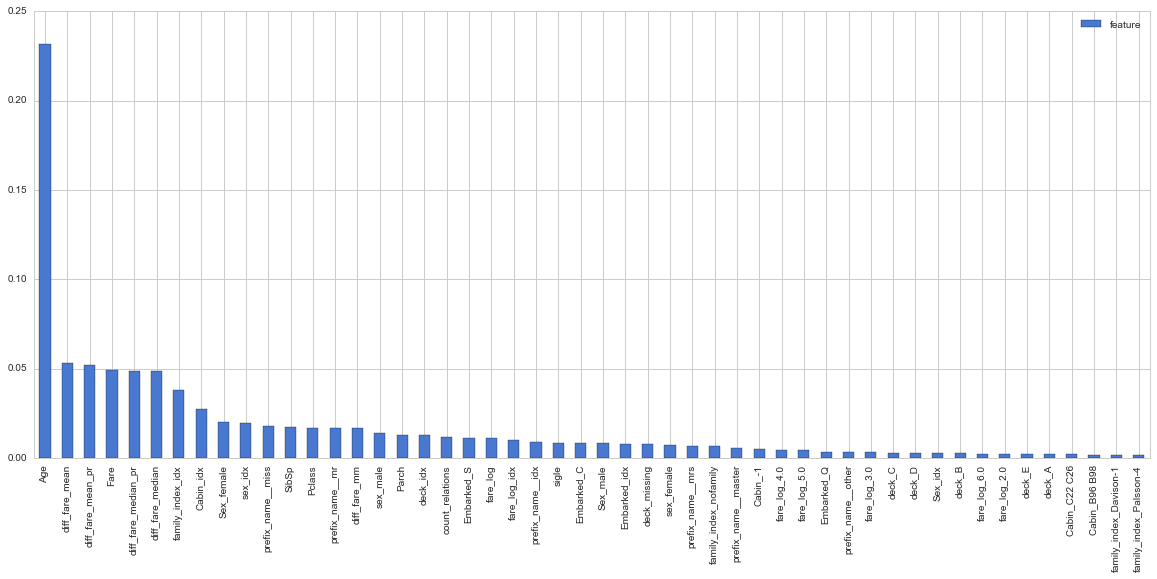

In [147]:
all_df = handle_cat_var(all_df, 'fare_log')
print iteration_modeling(all_df)

draw_importance_features(all_df, limit=50)

Looks more or less the same, let's focus on ticket

148    11
72      8
58      8
277     7
13      7
49      7
70      7
24      7
16      6
266     6
26      6
62      6
503     5
84      5
284     5
7       5
327     5
160     5
324     5
231     4
57      4
42      4
550     4
163     4
334     4
90      4
614     4
283     4
272     4
240     4
       ..
576     1
574     1
603     1
605     1
635     1
607     1
633     1
632     1
631     1
630     1
629     1
628     1
627     1
626     1
624     1
623     1
622     1
621     1
620     1
619     1
618     1
617     1
616     1
615     1
613     1
612     1
611     1
610     1
609     1
0       1
Name: ticket_index, dtype: int64


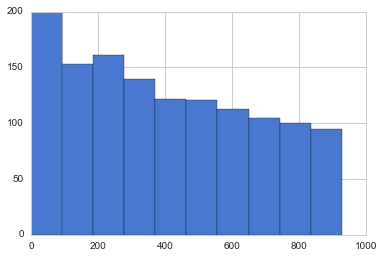

In [154]:
ticket_idx, ticket_labels = pd.factorize(all_df.Ticket)
all_df['ticket_index'] = ticket_idx

print all_df['ticket_index'].value_counts()
all_df['ticket_index'].hist()

{'max': 0.81931848043841593, 'mean': 0.79852770427931852, 'min': 0.77436767387040217}


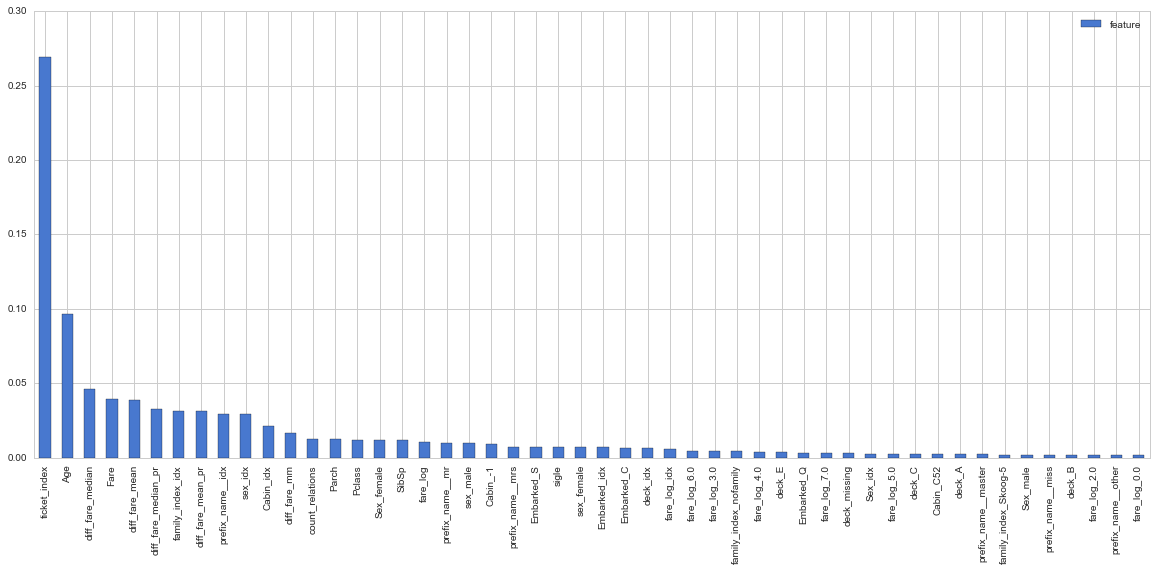

In [155]:
print iteration_modeling(all_df)

draw_importance_features(all_df, limit=50)

In [186]:
def map_age(x):
    if x < 0: return 'missing'
    if x < 6:  return '0_5'
    if x < 16: return '6_15'
    if x < 21: return '16_20'
    if x < 26: return '21_25'
    if x < 31: return '26_30'
    if x < 36: return '31_35'
    if x < 41: return '36_40'
    if x < 50: return '41_50'
    if x < 61: return '51_60'
    return '61+'

all_df['age_bucket'] = all_df['Age'].map(map_age)
print all_df['age_bucket'].value_counts()


missing    263
21_25      194
26_30      168
16_20      134
41_50      114
31_35      113
36_40       98
51_60       78
6_15        59
0_5         56
61+         32
Name: age_bucket, dtype: int64


{'max': 0.82272735493851135, 'mean': 0.80176026936313505, 'min': 0.77891248523381384}


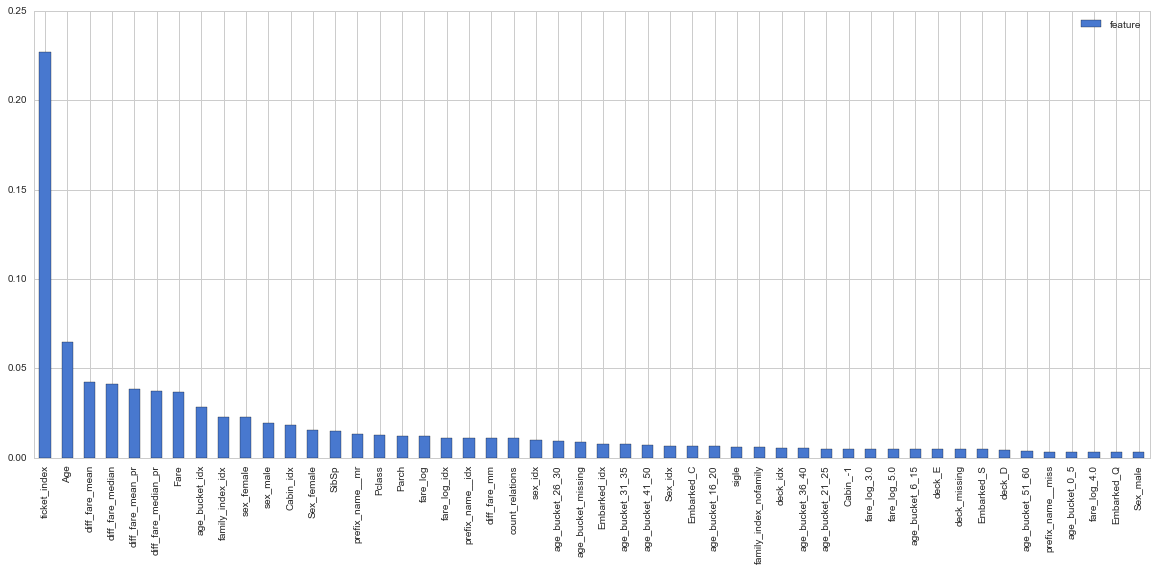

In [187]:
all_df = handle_cat_var(all_df, 'age_bucket')
print iteration_modeling(all_df)

draw_importance_features(all_df, limit=50)